# OTG Meeting 13 Feb 2025

## Triple Decomposition
---

For a tracer, $\theta$, the triple decomposition ([Joyce, 1977](https://github.com/andrewfagerheim/argo-Vault/blob/main/Readings/Joyce%201977.pdf)) follows the form:

$$
\theta = \theta^m + \theta^e + \theta^t
$$

where:
- _m_ is the mean scale (vertical: >100m, horizontal: >100km)
- _e_ is the mesoscale (vertical: 10-100m, horizontal: 10-100km)
- _t_ is the microscale (vertical: <10m, horizontal: <10m). 

In my analysis, I've defined each scale in the following way:
- $\theta^m$: Tracer profile filtered at l=100m, $\overline{\theta}$
- $\theta^e$: Tracer profile with the mean scale subtracted, $\theta$ - $\overline{\theta}$
- $\theta^t$: We're assuming this scale does not show up in Argo float measurements

[Garrett (2001)](https://apps.dtic.mil/sti/pdfs/[ADP013572.pdf](https://apps.dtic.mil/sti/pdfs/ADP013572.pdf) described the pathways from mean scale to dissipation in two ways: 
1. Variance is produced by mesoscale eddy stirring, then passed to microscale turbulence.
2. Mean variance is directly acted on by microscale turbulence.

<img src="https://github.com/user-attachments/assets/ebf43d99-d245-413d-8129-399c25db3ced" alt="Triple Decomposition Equation" width="400">

## Tracer variance equations w/ triple decomposition:
---

[Ferrari & Polzin (2005)](https://github.com/andrewfagerheim/argo-Vault/blob/main/Readings/Ferrari%202005.pdf) wrote the tracer variance equations using the triple decomposition expansion. I'm going to be incredibly brave and type them out in latex.

$$
0 = < u_e \theta_e > \cdot \nabla \theta_m - < \widetilde{u_t \theta_t} \cdot \nabla \theta_e >
$$

$$
-\frac{1}{2} < \chi > = < u_t \theta_t > \cdot \nabla \theta_m + <\widetilde{u_t \theta_t} \cdot \nabla \theta_e >
$$

$$
-\frac{1}{2} < \chi > = < u_t \theta_t > \cdot \nabla \theta_m + < u_e \theta_e > \cdot \nabla_n \theta_m
$$

Ferrari & Polzin (2005) uses the flux gradient relationship (which assumes isopycnals are nearly horizontal) to parametrize each term. Below I've listed the term first as it appears in the equations above, and then with the parametrization that can be calculated using Argo data.


$$
[1] < u_e \theta_e > \cdot \nabla_n \theta_m \approx -K_e (\nabla_n \theta_m)^2
$$

$$
[2] < \widetilde{u_t \theta_t}  \cdot \nabla \theta_e > \approx -K_{\rho} (\widetilde{\partial z \theta_e})^2
$$

$$
[3] <u_t \theta_t > \cdot \nabla \theta_m \approx -K_{\rho} (\partial z \theta_m)^2
$$

$$
[4] \chi
$$

where $K_e$ is mesoscale effective diffusivity and $K_{\rho}$ is diapycnal turbulent diffusivity. 

This raises a _**MAJOR CAVVEAT**_ of my current results: I've reached out to someone asking for their Argo-derived isopycnic diffusivity estimates but haven't heard back yet. So, I'm using a constant of $K_{\rho} = 10e-5$ in my notebooks currently. This means that what I'm currently describing as "variance" is currently _only_ impacted by the vertical derivative of a tracer. 

Notebook Terminology
-
In my notebooks I use terms like "mesoscale variance" or "mesoscale fraction," so I will define what I mean here:
- "Mesoscale Variance/Pathway:" term (2) above
- "Microscale Variance/Pathway:" term (3) above
- "Total Variance:" term (2) + term (3)
- "Mesoscale Variance Ratio:" term (2) / (term (2) + term (3))
- "Mesoscale Variance Ratio:" term (3) / (term (2) + term (3))

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
from flox.xarray import xarray_reduce
import os

In [3]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [290]:
COUNT = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_binned/COUNT.nc').COUNT
SIG0 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_binned/SIG0.nc').SIG0
CT = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_binned/CT.nc').CT
SA = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_binned/SA.nc').SA
CT_2 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_binned/CT_2.nc').CT_2
CT_3 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_binned/CT_3.nc').CT_3
SA_2 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_binned/SA_2.nc').SA_2
SA_3 = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_binned/SA_3.nc').SA_3
CT_2RAT = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_binned/CT_2RAT.nc').CT_2RAT
SA_2RAT = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_binned/SA_2RAT.nc').SA_2RAT

In [173]:
count_min = 50
mask = count < count_min
masked_count = count.where(mask)

In [28]:
ct_start = 0
ct_end   = 16
ct_norm  = colors.Normalize(vmin=ct_start, vmax=ct_end)
ct_cmap  = cmo.thermal

In [29]:
sa_start = 34.5
sa_end   = 36.5
sa_norm  = colors.Normalize(vmin=sa_start, vmax=sa_end)
sa_cmap  = cmo.haline

In [30]:
ctvar_start = 10**-12
ctvar_end   = 10**-8
ctvar_norm  = colors.LogNorm(vmin=ctvar_start, vmax=ctvar_end)
var_cmap  = cmo.matter_r

In [31]:
savar_start = 10**-14
savar_end   = 10**-9
savar_norm  = colors.LogNorm(vmin=savar_start, vmax=savar_end)

In [66]:
rat_cmap = cmo.dense

In [75]:
plot_dict = {
    'CT': {'norm': ct_norm, 'cmap': ct_cmap, 'title': 'Conservative Temperature'},
    'SA': {'norm': sa_norm, 'cmap': sa_cmap, 'title': 'Absolute Salinity'},
    'CT_2': {'norm': ctvar_norm, 'cmap': var_cmap, 'title': 'Mesoscale Variance of Temperature'},
    'CT_3': {'norm': ctvar_norm, 'cmap': var_cmap, 'title': 'Microscale Variance of Temperature'},
    'SA_2': {'norm': savar_norm, 'cmap': var_cmap, 'title': 'Mesoscale Variance of Salinity'},
    'SA_3': {'norm': savar_norm, 'cmap': var_cmap, 'title': 'Microscale Variance of Salinity'},
    'CT_2RAT': {'norm': None, 'cmap': rat_cmap, 'title': 'Ratio of Mesoscale Temperature Variance'},
    'SA_2RAT': {'norm': None, 'cmap': rat_cmap, 'title': 'Ratio of Mesoscale Salinity Variance'}}

## Plots

In [262]:
depth = 500
lon   = 18
lat   = 36
levels = [26,27,27.4,27.7,27.8]

In [293]:
ds  =  CT_2RAT
var = 'CT_2RAT'

In [296]:
print('Plotting {} given the following parameters:'.format(plot_dict[var]['title']))
print('depth: {}m'.format(ds.PRES_INTERPOLATED.sel(PRES_INTERPOLATED=depth,method='nearest').item()))
print('center lon: {}'.format(ds.lon_center.isel(lon_center=lon).item()))
print('center lat: {}'.format(ds.lat_center.isel(lat_center=lat).item()))
print('SIG0 levels: {}'.format(levels))

Plotting Ratio of Mesoscale Temperature Variance given the following parameters:
depth: 500m
center lon: -19.5
center lat: 34.5
SIG0 levels: [26, 27, 27.4, 27.7, 27.8]


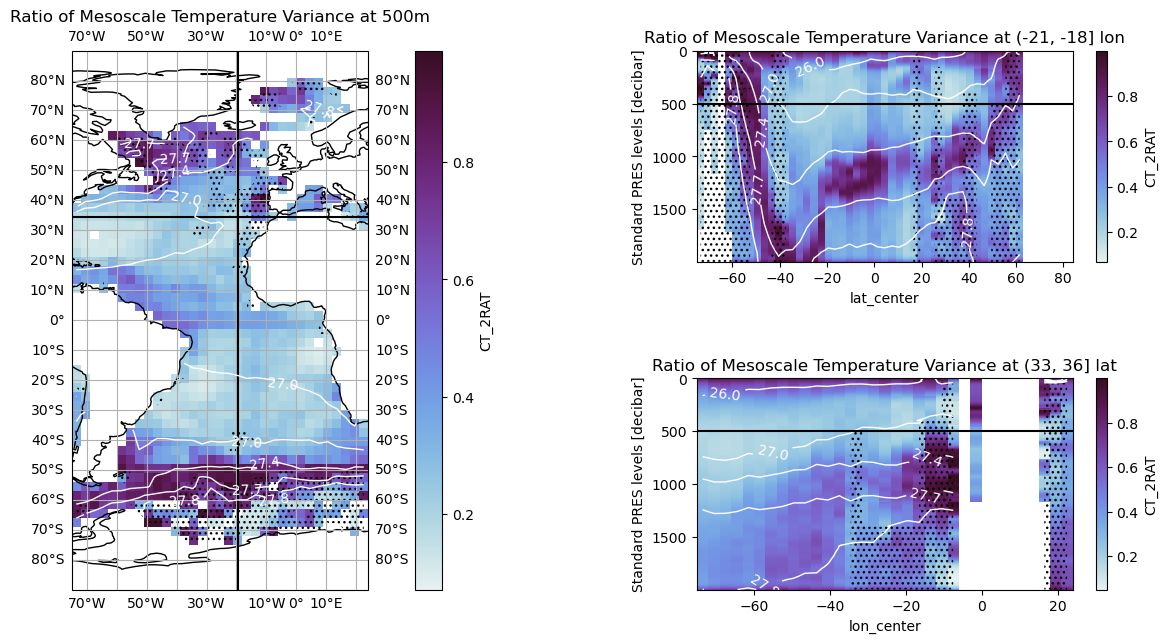

In [294]:
plt.figure(figsize=(20, 7))
gs = plt.GridSpec(2, 2, width_ratios=[2, 1])

ax1 = plt.subplot(gs[:, 0], projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.gridlines(xlocs=np.arange(-80, 30, 10), ylocs=np.arange(-90, 90, 10), draw_labels=True)
ax1.axvline(lon_center, color='k')
ax1.axhline(lat_center, color='k')
ds.sel(PRES_INTERPOLATED=depth, method='nearest').plot(x='lon_center', y='lat_center', ax=ax1, norm=plot_dict[var]['norm'], cmap=plot_dict[var]['cmap'])
masked_count.CT.sel(PRES_INTERPOLATED=depth).plot.contourf(x='lon_center', y='lat_center', levels=[0, 50], hatches=['...'], colors='none', ax=ax1, add_colorbar=False)
contour = SIG0.sel(PRES_INTERPOLATED=depth).plot.contour(x='lon_center', y='lat_center', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax1.set_title(f'{plot_dict[var]['title']} at {depth}m')

ax2 = plt.subplot(gs[0, 1])
ds.isel(lon_center=lon).plot(x='lat_center', y='PRES_INTERPOLATED', ax=ax2, norm=plot_dict[var]['norm'], cmap=plot_dict[var]['cmap'])
masked_count.CT.isel(lon_center=lon).plot.contourf(x='lat_center', y='PRES_INTERPOLATED', levels=[0, 50], hatches=['...'], colors='none', ax=ax2, add_colorbar=False)
contour = SIG0.isel(lon_center=lon).plot.contour(x='lat_center', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax2.invert_yaxis()
ax2.axhline(depth, color='k')
ax2.set_title(f'{plot_dict[var]['title']} at {ds_sa_binned.LONGITUDE_bins.isel(LONGITUDE_bins=lon).item()} lon')

ax4 = plt.subplot(gs[1, 1])
ds.isel(lat_center=lat).plot(x='lon_center', y='PRES_INTERPOLATED', ax=ax4, norm=plot_dict[var]['norm'], cmap=plot_dict[var]['cmap'])
masked_count.CT.isel(lat_center=lat).plot.contourf(x='lon_center', y='PRES_INTERPOLATED', levels=[0, 50], hatches=['...'], colors='none', ax=ax4, add_colorbar=False)
contour = SIG0.isel(lat_center=lat).plot.contour(x='lon_center', y='PRES_INTERPOLATED', levels=levels, colors='white', linewidths=1)
plt.clabel(contour, fmt='%1.1f', colors='white', fontsize=10)
ax4.invert_yaxis()
ax4.axhline(depth, color='k')
ax4.set_title(f'{plot_dict[var]['title']} at {ds_sa_binned.LATITUDE_bins.isel(LATITUDE_bins=lat).item()} lat')

plt.subplots_adjust(hspace=0.55)
plt.show()